# Multi-task Solution for Aspect Category Sentiment Analysis on Vietnamese Datasets

## 1. Một vài thông tin cơ bản
* Input: The text reviews in Vietnamese language.
* Output: 1 or N aspect and the corresponding sentiment
    * List of aspect: [SMELL, COLOUR, PACKING, SHIPPING, STAYINGPOWER, TEXTURE, PRICE, OTHERS]
    * List of sentiment: [Positive, Neutral, Negative]

**Example**:
* Input: Cây son có màu rất đẹp, còn rất lì nữa (The colour of the lipstick is beautiful, and it is very adhesive too)
* Output: COLOUR:Positive, STAYINGPOWER:Positive

## 2. Baselines
| Model                        | STL       |           | MTL       |           |
|------------------------------|-----------|-----------|-----------|-----------|
|                              | F1_ad (%) | F1_sc (%) | F1_ad (%) | F1_sc (%) |
| BiLSTM                       | 97.62     | 87.56     | 94.12     | 81.44     |
| BiGRU                        | 97.90     | 87.22     | 95.61     | 80.94     |
| BiLSTM + Conv1D              | 98.00     | 89.90     | 96.89     | 86.26     |
| BiGRU + Conv1D               | 98.09     | 91.01     | 97.51     | 86.92     |
| BiLSTM + BiGRU + Conv1D      | 97.92     | 90.15     | 96.63     | 85.65     |

## 3.Các khái niệm

### 3.1. STL (Single-Task Learning)
#### Định nghĩa
STL là phương pháp mà mỗi mô hình chỉ tập trung giải quyết một nhiệm vụ (task) duy nhất. Trong bài toán ABSA, các nhiệm vụ chính là:
* Phát hiện khía cạnh (Aspect Detection): Xác định xem bài đánh giá có đề cập đến các khía cạnh nào (ví dụ: giá cả, màu sắc, mùi hương, v.v.).
* Phân loại cảm xúc (Sentiment Classification): Với mỗi khía cạnh đã phát hiện, mô hình sẽ phân loại cảm xúc là tích cực, trung lập hay tiêu cực.
#### Triển khai
* Aspect Detection: Một mô hình đa nhãn (multi-label classification) để xác định xem bài đánh giá có chứa các khía cạnh nào.
* Sentiment Classification: Với mỗi khía cạnh, sẽ có một mô hình phân loại cảm xúc riêng biệt (ví dụ: mô hình cho màu sắc, mô hình cho giá cả, v.v.).
* Quy trình: Phát hiện khía cạnh trước, sau đó mới phân loại cảm xúc cho từng khía cạnh đã phát hiện. Nếu không phát hiện khía cạnh nào thì không phân loại cảm xúc cho khía cạnh đó.
### 3.2. MTL (Multi-Task Learning)
#### Định nghĩa
MTL là phương pháp huấn luyện một mô hình duy nhất để giải quyết đồng thời nhiều nhiệm vụ liên quan. Trong ABSA, mô hình sẽ cùng lúc phát hiện khía cạnh và phân loại cảm xúc cho từng khía cạnh đó.

#### Triển khai
* Shared Layers: Các lớp đầu vào và ẩn (hidden layers) được chia sẻ chung cho tất cả các nhiệm vụ.
* Task-specific Layers: Mỗi nhiệm vụ (phát hiện khía cạnh, phân loại cảm xúc cho từng khía cạnh) có các lớp đầu ra riêng.
* Quy trình: Mô hình đồng thời dự đoán khía cạnh và cảm xúc cho từng khía cạnh đó mà không cần chia thành hai bước riêng biệt.

### 3.3. Độ đo
#### F1_ad (F1-score for Aspect Detection):
Đây là độ đo F1-score được sử dụng để đánh giá khả năng phát hiện các khía cạnh (aspect) trong bài đánh giá. Mô hình sẽ xác định xem bài đánh giá có đề cập đến các khía cạnh nào (ví dụ: mùi hương, màu sắc, giá cả, v.v.). Công thức tính F1_ad:

$$\text{F1}_{ad} = 2 \times \frac{\text{Precision}_{ad} \times \text{Recall}_{ad}}{\text{Precision}_{ad} + \text{Recall}_{ad}}$$
Trong đó:

* $\text{Precision}_{ad}$: Độ chính xác phát hiện khía cạnh.
* $\text{Recall}_{ad}$: Độ phủ phát hiện khía cạnh.

#### F1_sc (F1-score for Sentiment Classification):
Đây là độ đo F1-score dùng để đánh giá khả năng phân loại cảm xúc (sentiment) cho từng khía cạnh đã được phát hiện (ví dụ: tích cực, trung lập, tiêu cực).Công thức tính F1_sc:

$$\text{F1}_{sc} = 2 \times \frac{\text{Precision}_{sc} \times \text{Recall}_{sc}}{\text{Precision}_{sc} + \text{Recall}_{sc}}$$

Trong đó:
* $\text{Precision}_{sc}$: Độ chính xác phân loại cảm xúc.
* $\text{Recall}_{sc}$: Độ phủ phân loại cảm xúc.

## 4. EDA

### Load dữ liệu

In [145]:
from os import path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mint.config import DATA_DIR

In [146]:
ViABSA_BP_dir = path.join(DATA_DIR, 'ViABSA_BP')
ViABSA_BP_Hotel_dir = path.join(ViABSA_BP_dir, 'ViABSA_Hotel')
ViABSA_BP_Restaurant_dir = path.join(ViABSA_BP_dir, 'ViABSA_Restaurant')


train_file = path.join(ViABSA_BP_dir, 'data_train.csv')
test_file = path.join(ViABSA_BP_dir, 'data_test.csv')
dev_file = path.join(ViABSA_BP_dir, 'data_dev.csv')

In [147]:
df = pd.read_csv(train_file)
df.head()

,data,stayingpower,texture,smell,price,others,colour,shipping,packing
0,"son đẹp lăm,sẽ ủng hộ tiếp , shipper cũng dễ t...",NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN
1,Son đẹp lắm nha mn tuy là son nội địa giá rẻ n...,NaN,positive,positive,positive,NaN,NaN,NaN,NaN
2,"Son màu lên chuẩn, đẹp tuy nhiên dễ khô nên cầ...",NaN,negative,NaN,NaN,NaN,positive,NaN,NaN
3,Công dụng: rất đẹp\nKết cấu: tốt\nĐộ bền màu: ...,positive,positive,NaN,NaN,NaN,positive,NaN,NaN
4,"Hàng gói siêu chắc chắn, packing xinh xỉu, đủ ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive


### Thống kê cơ bản

In [148]:
print(df.head())
print("\nThông tin tổng quan:")
print(df.info())
print("\nThống kê mô tả:")
print(df.describe(include='all'))

                                                data stayingpower   texture  \
0  son đẹp lăm,sẽ ủng hộ tiếp , shipper cũng dễ t...          NaN       NaN   
1  Son đẹp lắm nha mn tuy là son nội địa giá rẻ n...          NaN  positive   
2  Son màu lên chuẩn, đẹp tuy nhiên dễ khô nên cầ...          NaN  negative   
3  Công dụng: rất đẹp\nKết cấu: tốt\nĐộ bền màu: ...     positive  positive   
4  Hàng gói siêu chắc chắn, packing xinh xỉu, đủ ...          NaN       NaN   

      smell     price others    colour  shipping   packing  
0       NaN       NaN    NaN       NaN  positive       NaN  
1  positive  positive    NaN       NaN       NaN       NaN  
2       NaN       NaN    NaN  positive       NaN       NaN  
3       NaN       NaN    NaN  positive       NaN       NaN  
4       NaN       NaN    NaN       NaN       NaN  positive  

Thông tin tổng quan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12981 entries, 0 to 12980
Data columns (total 9 columns):
 #   Column        Non-Null C

### Phân phối các khía cạnh

In [149]:
aspects = ['stayingpower', 'texture', 'smell', 'price', 'others', 'colour', 'shipping', 'packing']

for aspect in aspects:
    df[aspect + '_exists'] = df[aspect].notna()

aspect_counts = df[[a + '_exists' for a in aspects]].sum()
aspect_counts.index = aspects

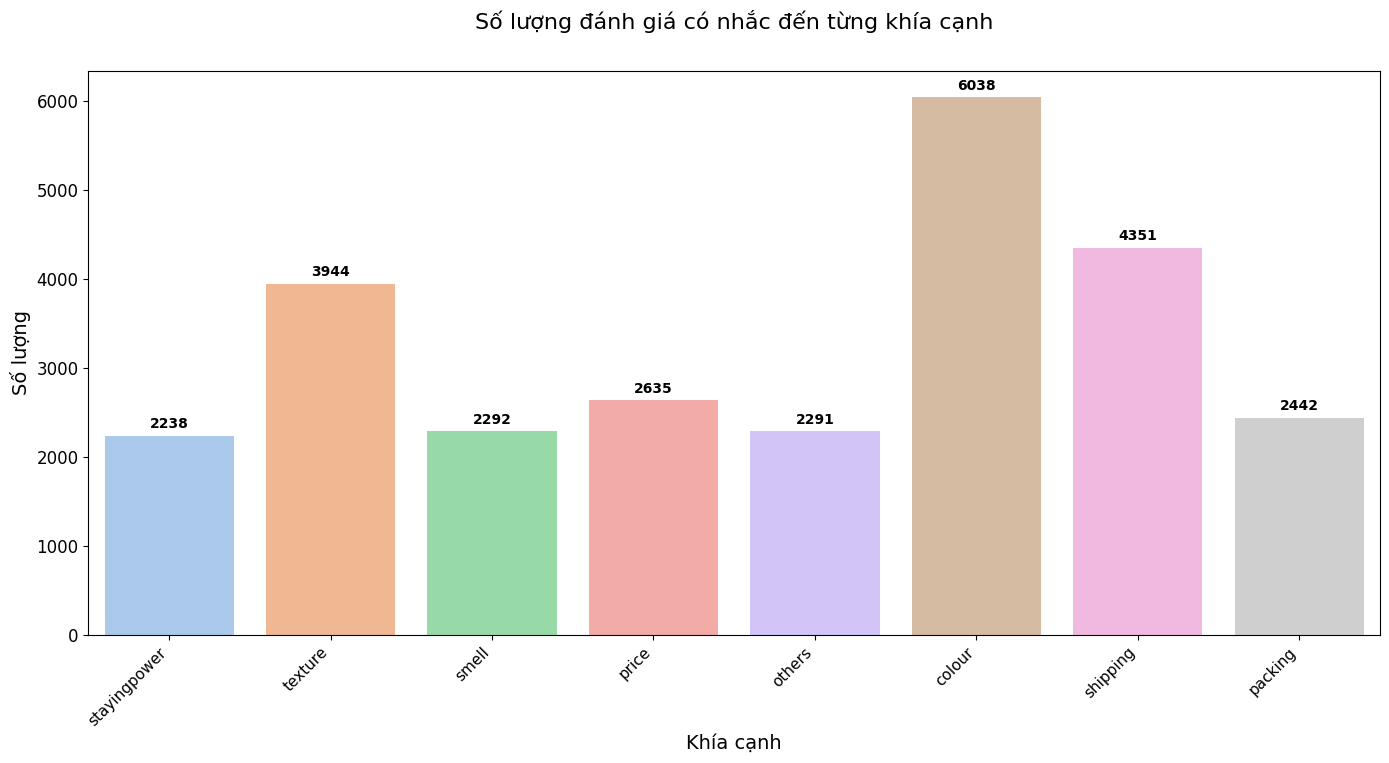

In [150]:
plt.figure(figsize=(14, 8))
bp_aspect_barplot = sns.barplot(x=aspect_counts.index, y=aspect_counts.values, hue=aspect_counts.index, palette="pastel", legend=False)
plt.title("Số lượng đánh giá có nhắc đến từng khía cạnh", fontsize=16, pad=30)
plt.ylabel("Số lượng", fontsize=14)
plt.xlabel("Khía cạnh", fontsize=14)

# Cải thiện hiển thị nhãn trục x để hiện tất cả khía cạnh
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=12)

# Thêm text số lượng trên đầu các cây cột
for p in bp_aspect_barplot.patches:
    height = p.get_height()
    if height <= 0:
        continue
    bp_aspect_barplot.text(p.get_x() + p.get_width() / 2., height + 50, int(height), ha="center", va="bottom", fontsize=10, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Tăng khoảng cách phía dưới để tất cả nhãn hiện rõ
plt.show()

### Phân bố cảm xúc theo từng khía cạnh

In [151]:
sentiment_aspects = {}

for aspect in aspects:
    sentiment_aspects[aspect] = df[aspect].value_counts()

# Chuẩn bị dữ liệu để vẽ biểu đồ
sentiment_df = pd.DataFrame()
for aspect in aspects:
    temp = df[aspect].value_counts().rename_axis('sentiment').reset_index(name='count')
    temp['aspect'] = aspect
    sentiment_df = pd.concat([sentiment_df, temp], ignore_index=True)
sentiment_df = sentiment_df.dropna()

25


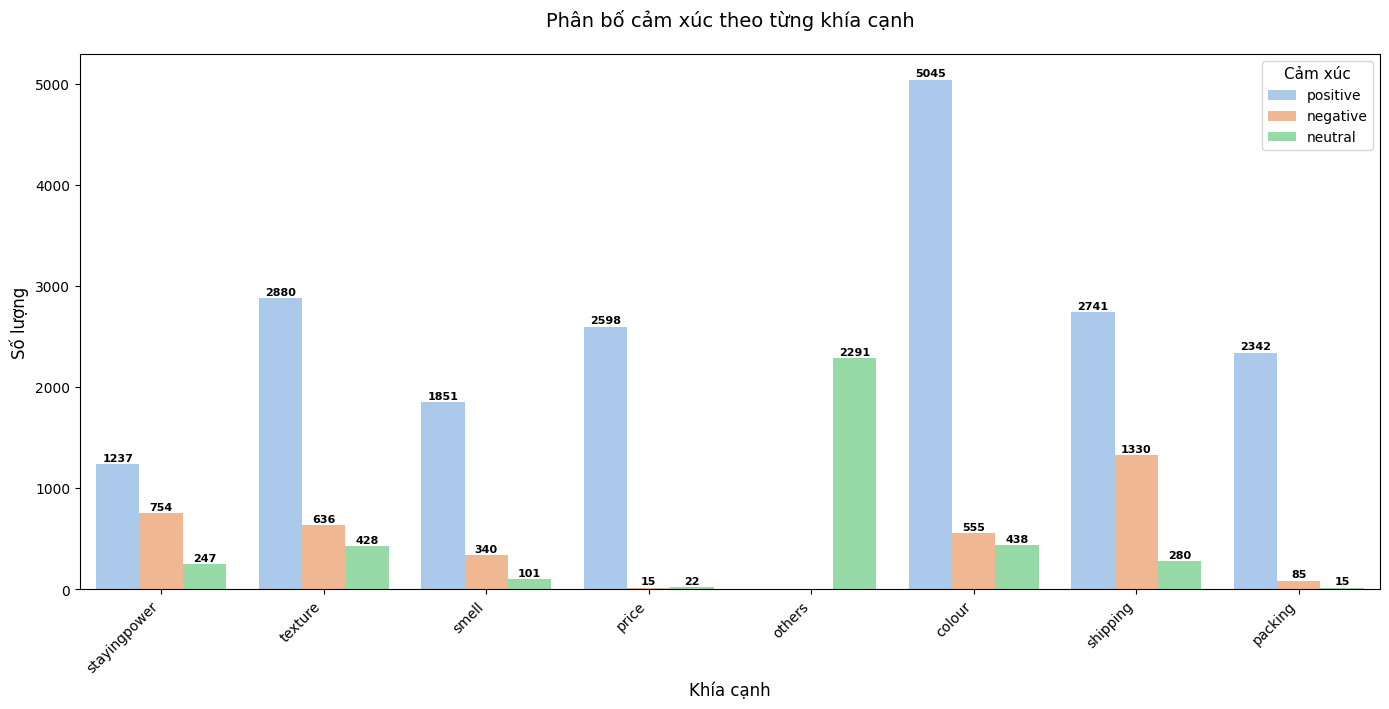

In [152]:
plt.figure(figsize=(14, 7))
barplot = sns.barplot(x='aspect', y='count', hue='sentiment', data=sentiment_df, palette="pastel")
plt.title("Phân bố cảm xúc theo từng khía cạnh", fontsize=14, pad=20)
plt.ylabel("Số lượng", fontsize=12)
plt.xlabel("Khía cạnh", fontsize=12)

# Cải thiện hiển thị nhãn trục x
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Cảm xúc', fontsize=10, title_fontsize=11)

# Thêm text số lượng trên đầu các cây cột
for p in barplot.patches:
    height = p.get_height()
    if height <= 0:
        continue
    barplot.text(p.get_x() + p.get_width() / 2., height + 10, int(height), ha="center", va="bottom", fontsize=8, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Tăng khoảng cách phía dưới để nhãn không bị cắt
print(len(barplot.patches))
plt.show()

### Phân bố số lượng khía cạnh trong mỗi đánh giá

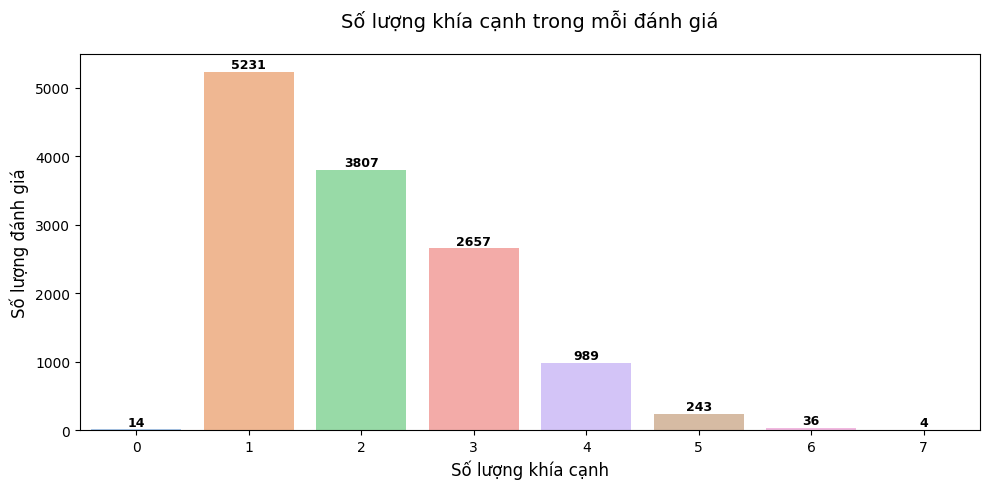

In [153]:
df['num_aspects'] = df[[a + '_exists' for a in aspects]].sum(axis=1)

plt.figure(figsize=(10, 5))
bp_count_plot = sns.countplot(x='num_aspects', hue='num_aspects', data=df, palette="pastel", legend=False)
plt.title("Số lượng khía cạnh trong mỗi đánh giá", fontsize=14, pad=20)
plt.xlabel("Số lượng khía cạnh", fontsize=12)
plt.ylabel("Số lượng đánh giá", fontsize=12)

# Cải thiện hiển thị
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Thêm text số lượng trên đầu các cây cột
for p in bp_count_plot.patches:
    height = p.get_height()
    if height <= 0:
        continue
    bp_count_plot.text(p.get_x() + p.get_width() / 2., height + 10, int(height), ha="center", va="bottom", fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. EDA cho dữ liệu ViABSA_Restaurant

### Load dữ liệu Restaurant

In [154]:
# Load dữ liệu restaurant
restaurant_train_file = path.join(DATA_DIR, 'ViABSA_Restaurant', 'data_train.csv')
restaurant_df = pd.read_csv(restaurant_train_file)

print("Thông tin cơ bản về dữ liệu Restaurant:")
print(f"Shape: {restaurant_df.shape}")
print("\nCác cột trong dữ liệu:")
print(restaurant_df.columns.tolist())
print("\nMẫu dữ liệu:")
restaurant_df.head()

Thông tin cơ bản về dữ liệu Restaurant:
Shape: (2961, 13)

Các cột trong dữ liệu:
['Review', 'AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL']

Mẫu dữ liệu:


,Review,AMBIENCE#GENERAL,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE&OPTIONS,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE&OPTIONS,LOCATION#GENERAL,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,RESTAURANT#PRICES,SERVICE#GENERAL
0,"_ Ảnh chụp từ hôm qua, đi chơi với gia đình và...",0,0,0,0,0,3,3,0,0,0,0,0
1,"_Hương vị thơm ngon, ăn cay cay rất thích, nêm...",1,0,0,0,3,1,1,0,1,0,3,2
2,- 1 bàn tiệc hoành tráng 3 đứa ăn no muốn tắt ...,2,0,0,0,1,1,1,2,1,1,0,1
3,- Các bạn nhìn cái chảo này có to không 🙄🙄🙄- T...,0,0,0,0,0,1,1,0,1,0,0,0
4,"- Cháo: có nhiều hương cho các bạn chọn, nhưng...",0,0,0,0,0,1,1,0,0,0,0,0


### Thống kê cơ bản cho Restaurant data

In [155]:
# Lấy danh sách các khía cạnh (bỏ cột Review)
restaurant_aspects = [col for col in restaurant_df.columns if col != 'Review']
print(f"Số lượng khía cạnh: {len(restaurant_aspects)}")
print(f"Các khía cạnh: {restaurant_aspects}")

# Kiểm tra giá trị unique của một khía cạnh để hiểu format dữ liệu
print(f"\nGiá trị unique của khía cạnh đầu tiên ({restaurant_aspects[0]}):")
print(restaurant_df[restaurant_aspects[0]].value_counts().sort_index())

# Tạo biến để kiểm tra sự tồn tại của từng khía cạnh (khác 0)
for aspect in restaurant_aspects:
    restaurant_df[aspect + '_exists'] = restaurant_df[aspect] != 0

# Đếm số lượng đánh giá có nhắc đến từng khía cạnh
restaurant_aspect_counts = restaurant_df[[a + '_exists' for a in restaurant_aspects]].sum()
restaurant_aspect_counts.index = restaurant_aspects

print("\nThống kê cơ bản:")
print(restaurant_df.info())
print(f"\nTổng số reviews: {len(restaurant_df)}")
print(f"Trung bình số khía cạnh per review: {restaurant_aspect_counts.sum() / len(restaurant_df):.2f}")

Số lượng khía cạnh: 12
Các khía cạnh: ['AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL']

Giá trị unique của khía cạnh đầu tiên (AMBIENCE#GENERAL):
AMBIENCE#GENERAL
0    2224
1     513
2      92
3     132
Name: count, dtype: int64

Thống kê cơ bản:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2961 entries, 0 to 2960
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Review                           2961 non-null   object
 1   AMBIENCE#GENERAL                 2961 non-null   int64 
 2   DRINKS#PRICES                    2961 non-null   int64 
 3   DRINKS#QUALITY                   2961 non-null   int64 
 4   DRINKS#STYLE&OPTIONS             2961 non-null   int64 
 5   FOOD#PRICES         

### Phân phối các khía cạnh Restaurant

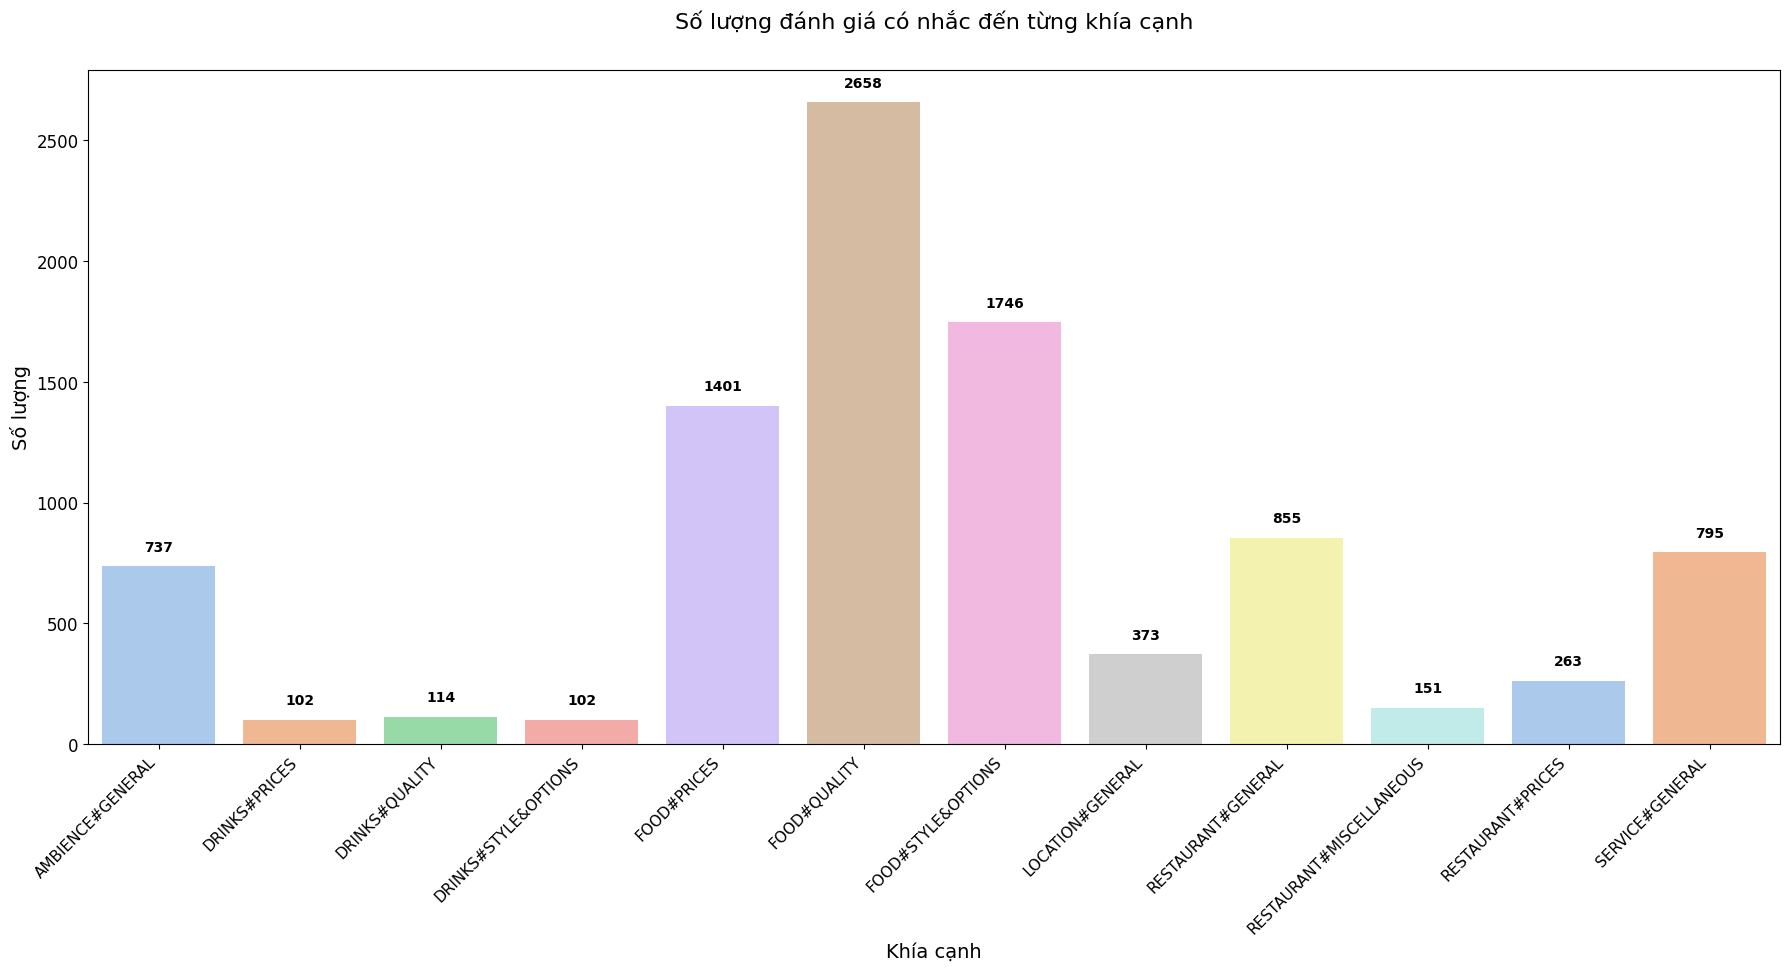

In [156]:
plt.figure(figsize=(18, 10))
restaurant_aspect_barplot = sns.barplot(x=restaurant_aspect_counts.index, y=restaurant_aspect_counts.values, hue=restaurant_aspect_counts.index, palette="pastel", legend=False)
plt.title("Số lượng đánh giá có nhắc đến từng khía cạnh", fontsize=16, pad=30)
plt.ylabel("Số lượng", fontsize=14)
plt.xlabel("Khía cạnh", fontsize=14)

# Cải thiện hiển thị nhãn trục x để hiện tất cả khía cạnh
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=12)

# Thêm text số lượng trên đầu các cây cột
for p in restaurant_aspect_barplot.patches:
    height = p.get_height()
    if height <= 0:
        continue
    restaurant_aspect_barplot.text(p.get_x() + p.get_width() / 2., height + 50, int(height), ha="center", va="bottom", fontsize=10, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Tăng khoảng cách phía dưới để tất cả nhãn hiện rõ
plt.show()

### Phân bố cảm xúc theo từng khía cạnh Restaurant

In [157]:
restaurant_sentiment_aspects = {}

for aspect in restaurant_aspects:
    restaurant_sentiment_aspects[aspect] = restaurant_df[aspect].value_counts()

# Tạo mapping cho sentiment labels
sentiment_mapping = {0: 'None', 1: 'Positive', 2: 'Neutral', 3: 'Negative'}

# Chuẩn bị dữ liệu để vẽ biểu đồ
restaurant_sentiment_df = pd.DataFrame()
for aspect in restaurant_aspects:
    temp = restaurant_df[restaurant_df[aspect] != 0][aspect].value_counts().rename_axis('sentiment').reset_index(name='count')
    temp['sentiment'] = temp['sentiment'].map(sentiment_mapping)
    temp['aspect'] = aspect
    restaurant_sentiment_df = pd.concat([restaurant_sentiment_df, temp], ignore_index=True)
restaurant_sentiment_df = restaurant_sentiment_df.dropna()

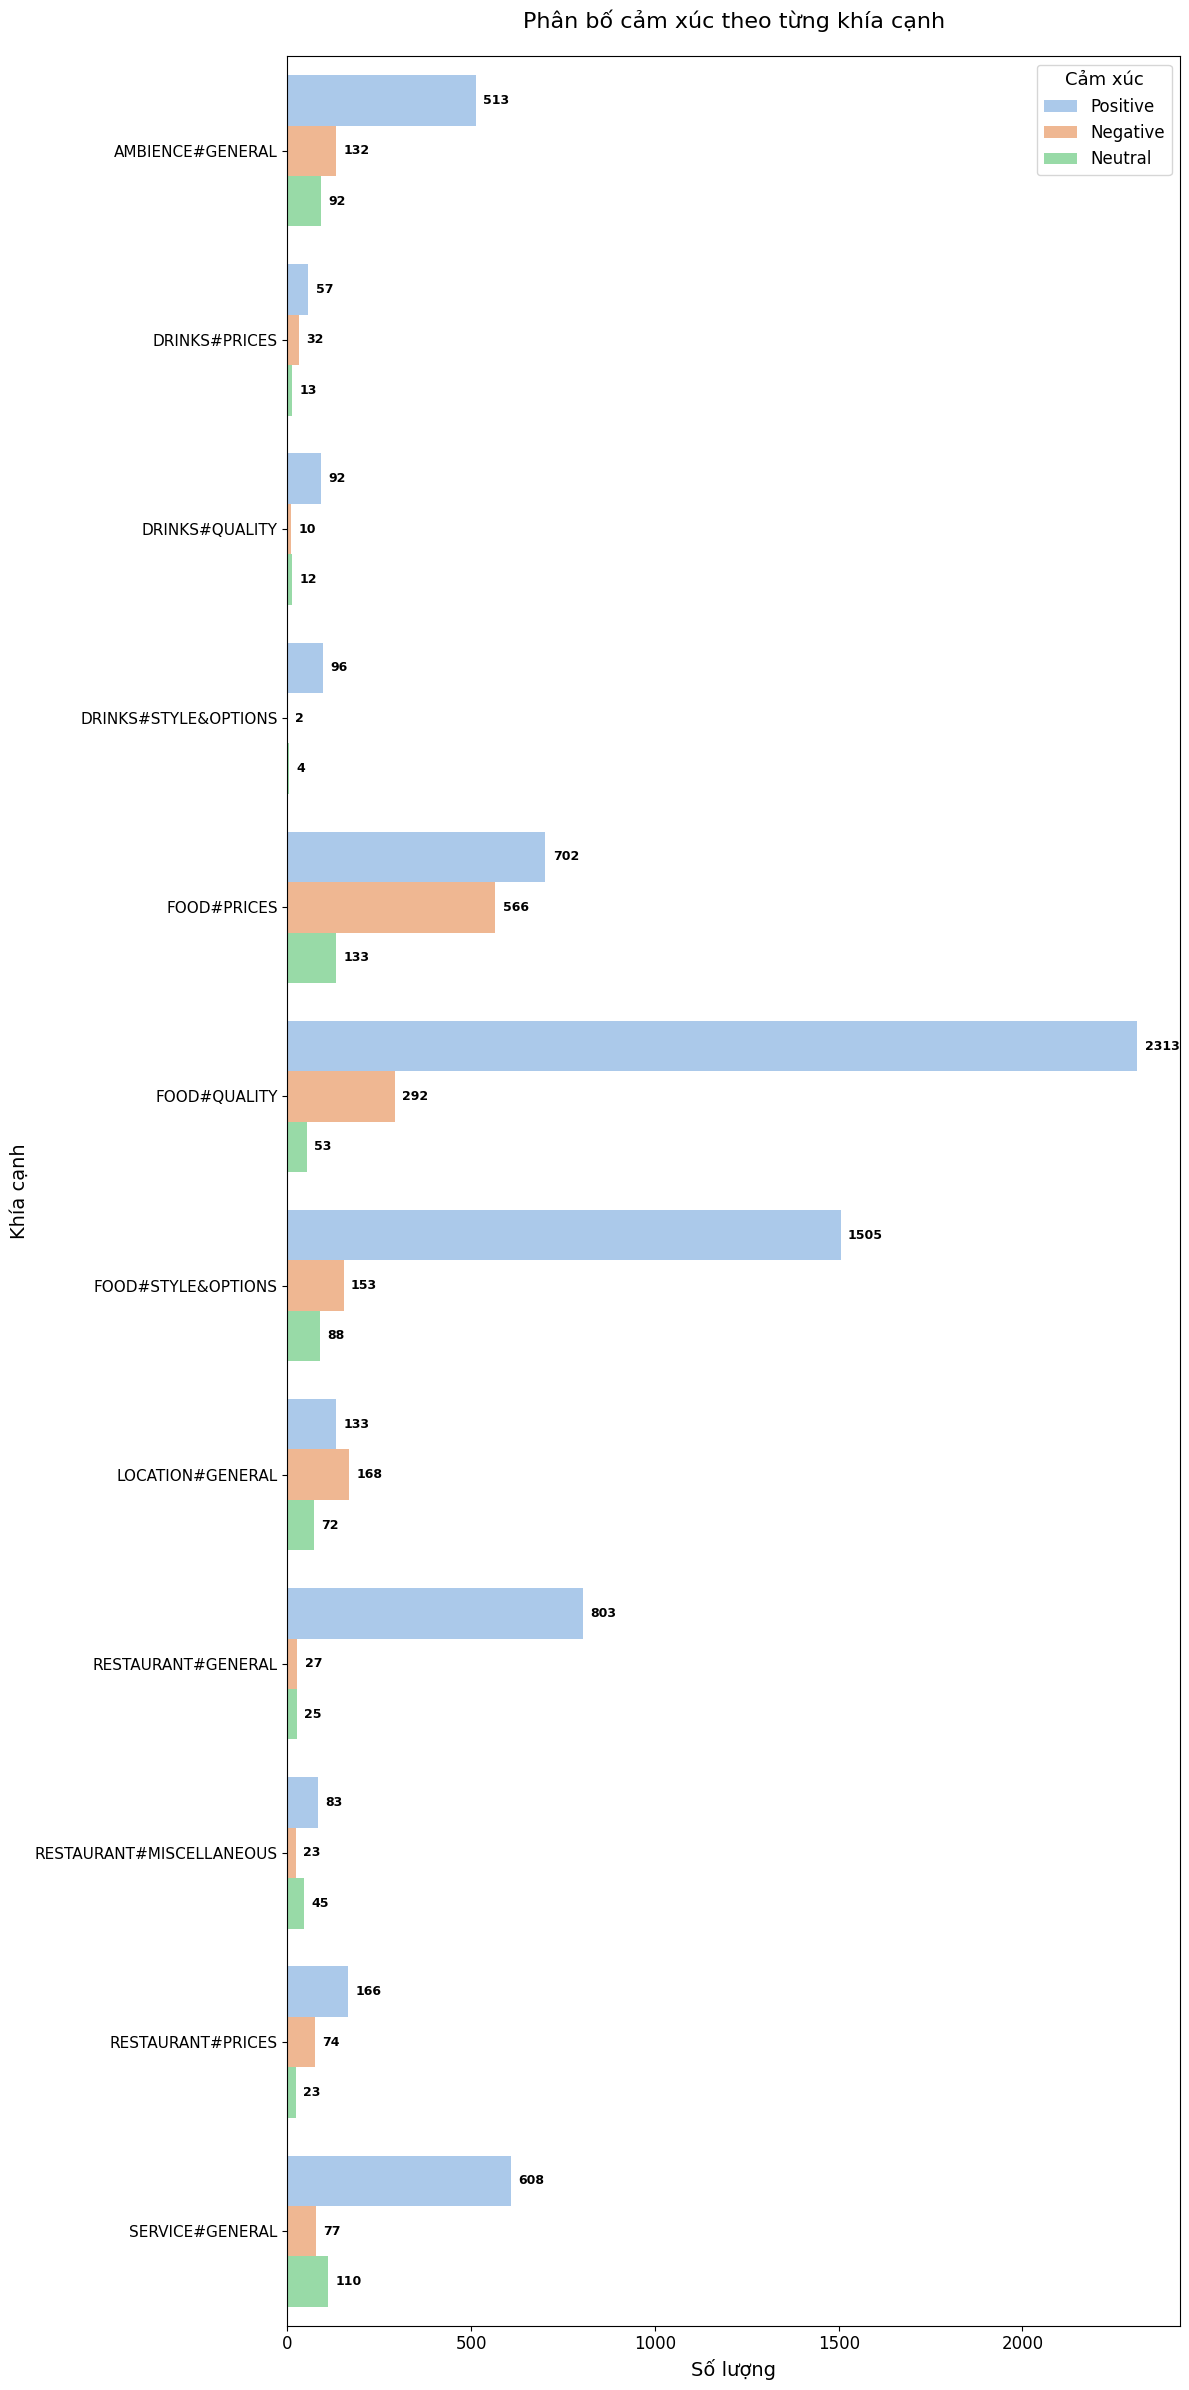

In [158]:
plt.figure(figsize=(12, 24))  # Giảm chiều rộng, tăng chiều cao để biểu đồ ngang đẹp hơn

# Biểu đồ cột ngang: trục y là 'aspect', trục x là 'count'
restaurant_barplot = sns.barplot(y='aspect', x='count', hue='sentiment', data=restaurant_sentiment_df, palette="pastel")

plt.title("Phân bố cảm xúc theo từng khía cạnh", fontsize=16, pad=20)
plt.xlabel("Số lượng", fontsize=14)
plt.ylabel("Khía cạnh", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=11)
plt.legend(title='Cảm xúc', fontsize=12, title_fontsize=13)

# Thêm số lượng trên đầu mỗi thanh ngang
for p in restaurant_barplot.patches:
    width = p.get_width()
    if width <= 0:
        continue
    restaurant_barplot.text(width + 20, p.get_y() + p.get_height() / 2., int(width), 
                            ha="left", va="center", fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


### Phân bố số lượng khía cạnh trong mỗi đánh giá Restaurant

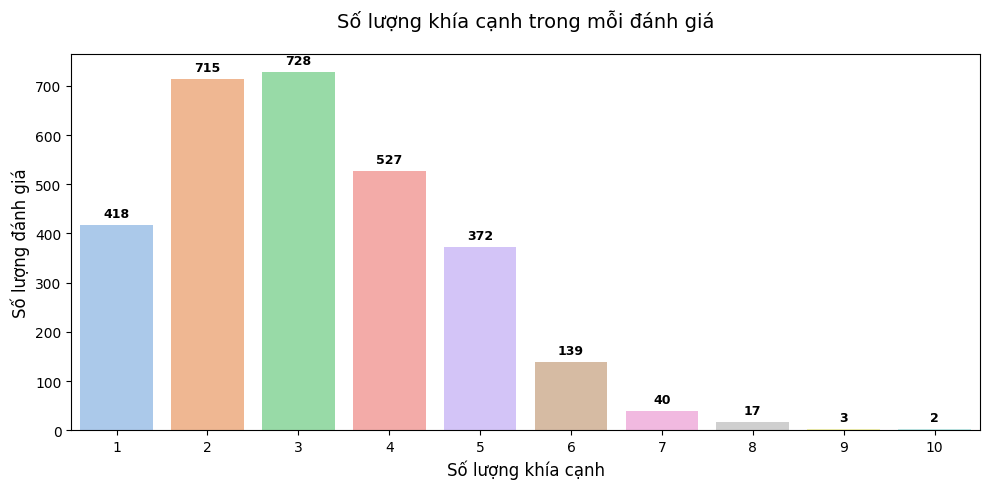

In [159]:
restaurant_df['num_aspects'] = restaurant_df[[a + '_exists' for a in restaurant_aspects]].sum(axis=1)

plt.figure(figsize=(10, 5))
restaurant_count_plot = sns.countplot(x='num_aspects', hue='num_aspects', data=restaurant_df, palette="pastel", legend=False)
plt.title("Số lượng khía cạnh trong mỗi đánh giá", fontsize=14, pad=20)
plt.xlabel("Số lượng khía cạnh", fontsize=12)
plt.ylabel("Số lượng đánh giá", fontsize=12)

# Cải thiện hiển thị
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Thêm text số lượng trên đầu các cây cột
for p in restaurant_count_plot.patches:
    height = p.get_height()
    if height <= 0:
        continue
    restaurant_count_plot.text(p.get_x() + p.get_width() / 2., height + 10, int(height), ha="center", va="bottom", fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. EDA cho dữ liệu ViABSA_Hotel

### Load dữ liệu Hotel

In [160]:
# Load dữ liệu hotel
hotel_train_file = path.join(DATA_DIR, 'ViABSA_Hotel', 'data_train.csv')
hotel_df = pd.read_csv(hotel_train_file)

print("Thông tin cơ bản về dữ liệu Hotel:")
print(f"Shape: {hotel_df.shape}")
print("\nCác cột trong dữ liệu:")
print(hotel_df.columns.tolist())
print("\nMẫu dữ liệu:")
hotel_df.head()

Thông tin cơ bản về dữ liệu Hotel:
Shape: (3000, 35)

Các cột trong dữ liệu:
['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL']

Mẫu dữ liệu:


,Review,FACILITIES#CLEANLINESS,FACILITIES#COMFORT,FACILITIES#DESIGN&FEATURES,FACILITIES#GENERAL,FACILITIES#MISCELLANEOUS,FACILITIES#PRICES,FACILITIES#QUALITY,FOOD&DRINKS#MISCELLANEOUS,FOOD&DRINKS#PRICES,...,ROOMS#PRICES,ROOMS#QUALITY,ROOM_AMENITIES#CLEANLINESS,ROOM_AMENITIES#COMFORT,ROOM_AMENITIES#DESIGN&FEATURES,ROOM_AMENITIES#GENERAL,ROOM_AMENITIES#MISCELLANEOUS,ROOM_AMENITIES#PRICES,ROOM_AMENITIES#QUALITY,SERVICE#GENERAL
0,Rộng rãi KS mới nhưng rất vắng. Các dịch vụ ch...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Địa điểm thuận tiện, trong vòng bán kính 1,5km...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Phục vụ, view đẹp, vị trí",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,"thuận tiện , sạch sẽ , vui vẻ hài lòng",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Vị trí đẹp; Có quán bar view đẹp; Nhân viên th...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Thống kê cơ bản cho Hotel data

In [161]:
# Lấy danh sách các khía cạnh (bỏ cột Review)
hotel_aspects = [col for col in hotel_df.columns if col != 'Review']
print(f"Số lượng khía cạnh: {len(hotel_aspects)}")
print(f"Các khía cạnh: {hotel_aspects}")

# Kiểm tra giá trị unique của một khía cạnh để hiểu format dữ liệu
print(f"\nGiá trị unique của khía cạnh đầu tiên ({hotel_aspects[0]}):")
print(hotel_df[hotel_aspects[0]].value_counts().sort_index())

# Tạo biến để kiểm tra sự tồn tại của từng khía cạnh (khác 0)
for aspect in hotel_aspects:
    hotel_df[aspect + '_exists'] = hotel_df[aspect] != 0

# Đếm số lượng đánh giá có nhắc đến từng khía cạnh
hotel_aspect_counts = hotel_df[[a + '_exists' for a in hotel_aspects]].sum()
hotel_aspect_counts.index = hotel_aspects

print("\nThống kê cơ bản:")
print(hotel_df.info())
print(f"\nTổng số reviews: {len(hotel_df)}")
print(f"Trung bình số khía cạnh per review: {hotel_aspect_counts.sum() / len(hotel_df):.2f}")

Số lượng khía cạnh: 34
Các khía cạnh: ['FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL']

Giá trị unique của khía cạnh đầu tiên (FACILITIES#CLEANLINESS):
FACILITIES#CLEANLINESS
0    2828
1     121
2      50
3       1
Name: count, dtype: int64

Thống kê cơ bản:
<clas

### Phân phối các khía cạnh Hotel

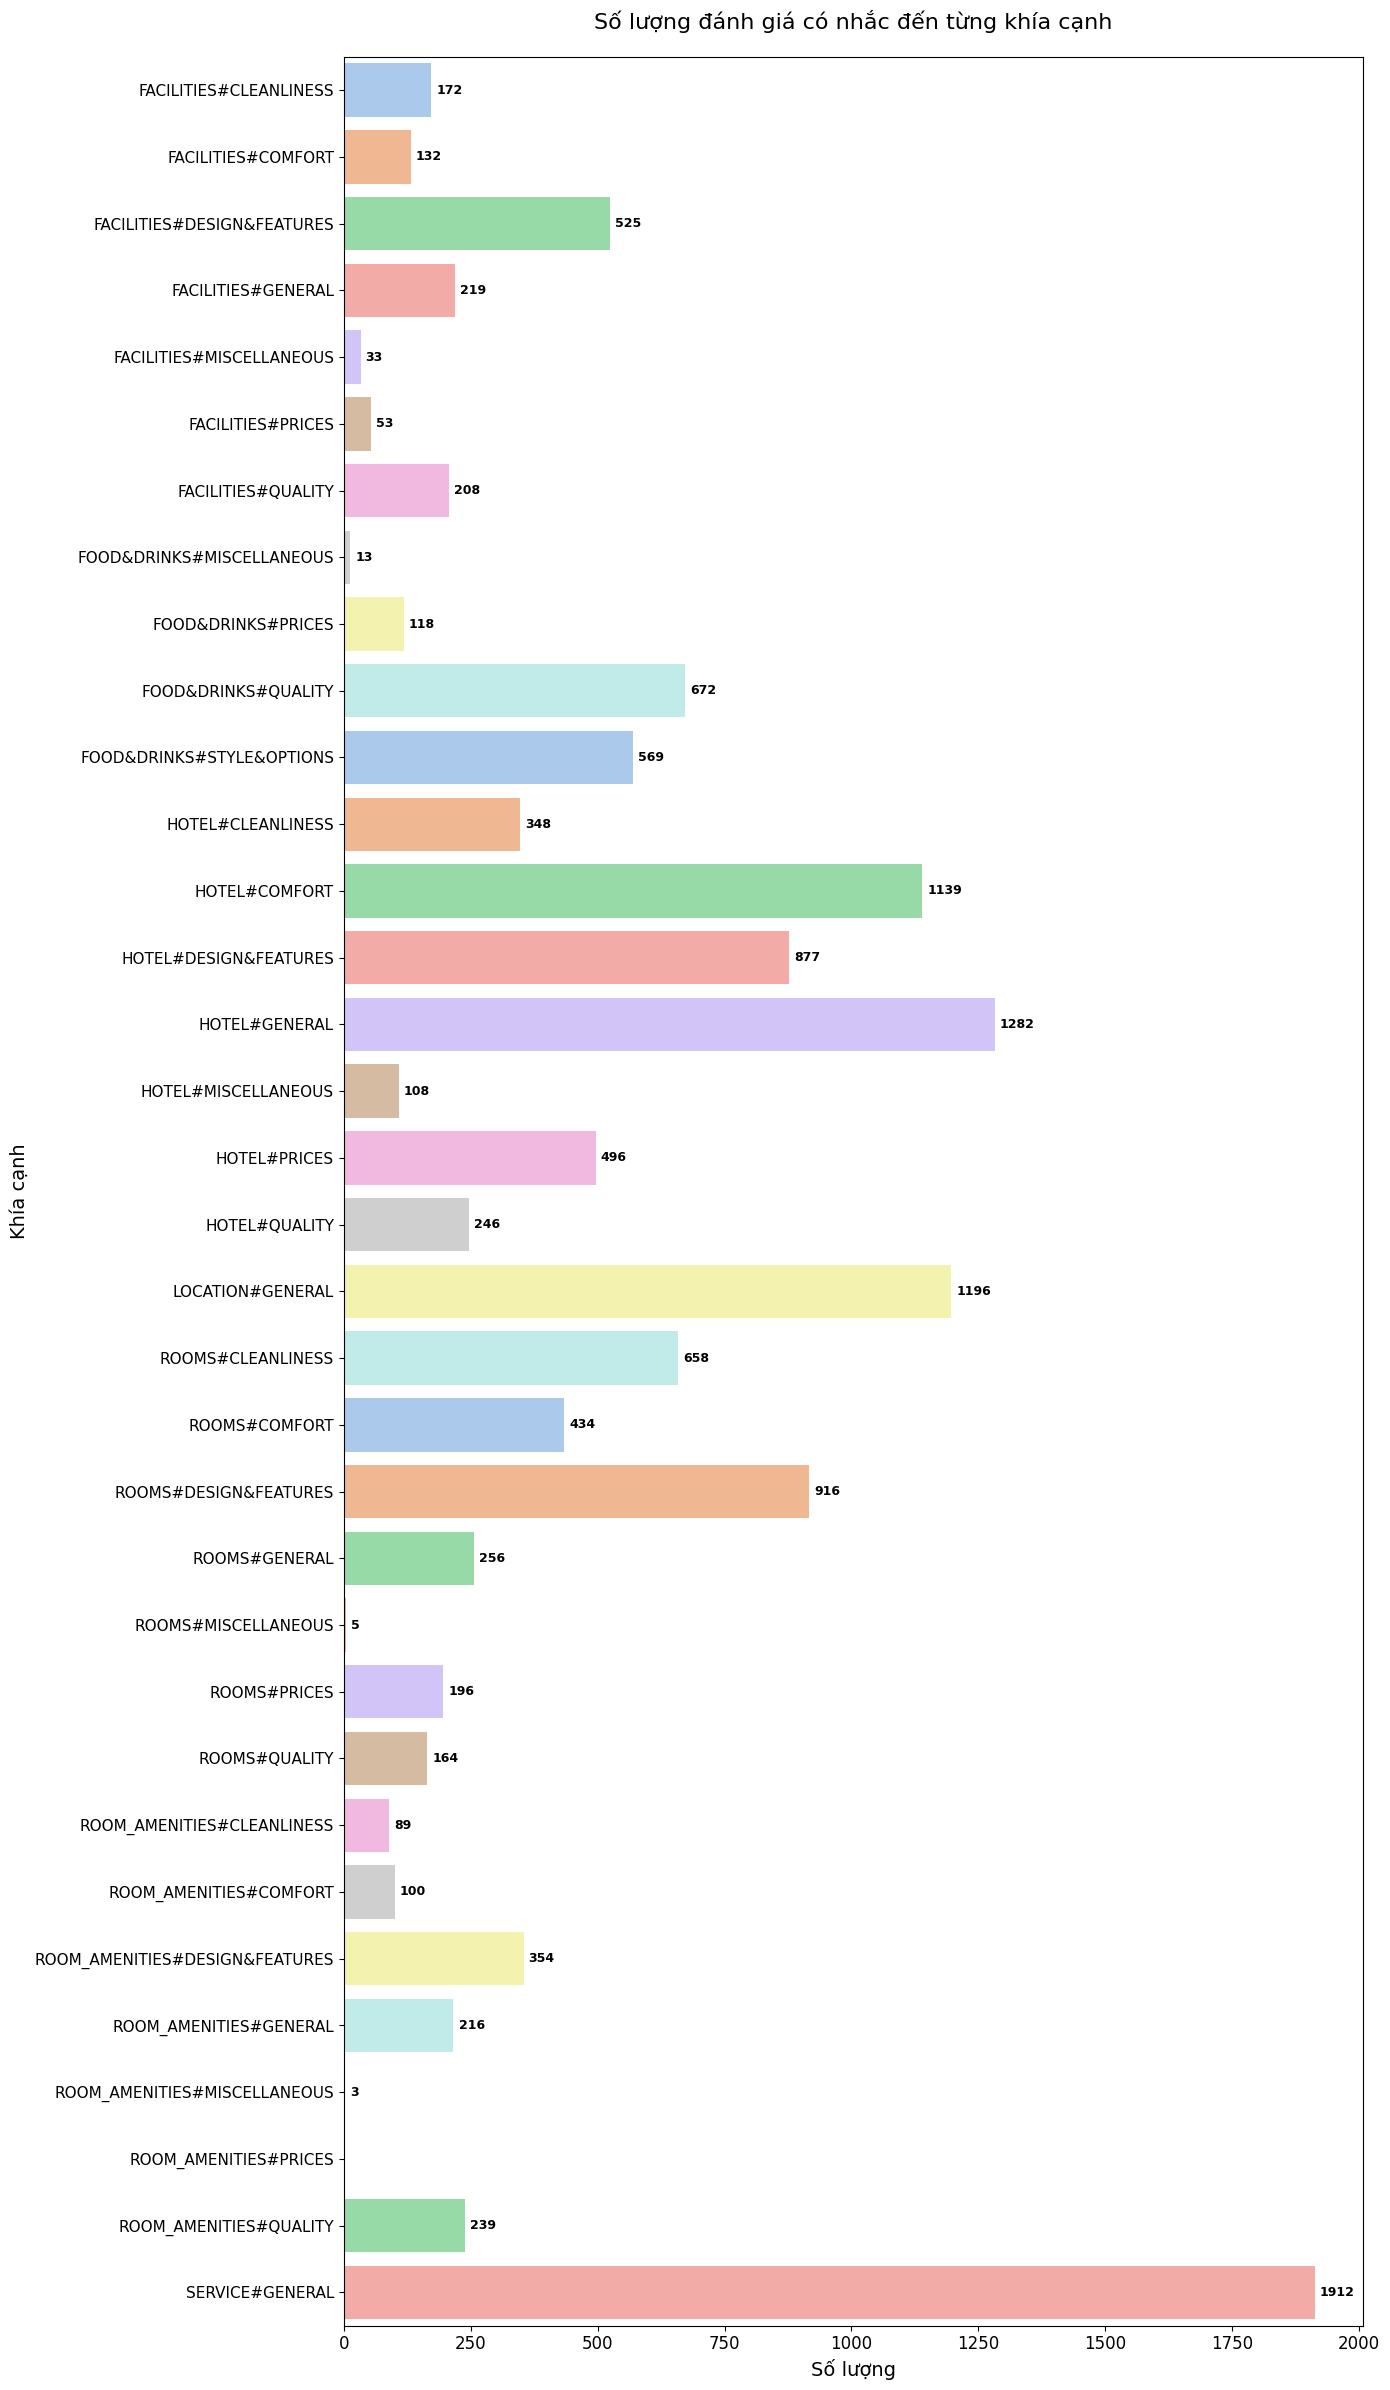

In [162]:
plt.figure(figsize=(14, 24))  # Chiều cao lớn để mỗi khía cạnh có đủ không gian

# Vẽ biểu đồ cột ngang
hotel_aspect_barplot = sns.barplot(
    y=hotel_aspect_counts.index,
    x=hotel_aspect_counts.values,
    hue=hotel_aspect_counts.index,  # Có thể bỏ nếu không cần nhiều màu
    palette="pastel",
    legend=False
)

plt.title("Số lượng đánh giá có nhắc đến từng khía cạnh", fontsize=16, pad=20)
plt.xlabel("Số lượng", fontsize=14)
plt.ylabel("Khía cạnh", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=11)

# Hiển thị số trên cột
for p in hotel_aspect_barplot.patches:
    width = p.get_width()
    if width <= 0:
        continue
    hotel_aspect_barplot.text(width + 10, p.get_y() + p.get_height() / 2., int(width),
                              ha="left", va="center", fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


### Phân bố cảm xúc theo từng khía cạnh Hotel

In [163]:
hotel_sentiment_aspects = {}

for aspect in hotel_aspects:
    hotel_sentiment_aspects[aspect] = hotel_df[aspect].value_counts()

# Tạo mapping cho sentiment labels (tương tự Restaurant)
sentiment_mapping = {0: 'None', 1: 'Positive', 2: 'Neutral', 3: 'Negative'}

# Chuẩn bị dữ liệu để vẽ biểu đồ
hotel_sentiment_df = pd.DataFrame()
for aspect in hotel_aspects:
    temp = hotel_df[hotel_df[aspect] != 0][aspect].value_counts().rename_axis('sentiment').reset_index(name='count')
    temp['sentiment'] = temp['sentiment'].map(sentiment_mapping)
    temp['aspect'] = aspect
    hotel_sentiment_df = pd.concat([hotel_sentiment_df, temp], ignore_index=True)
hotel_sentiment_df = hotel_sentiment_df.dropna()

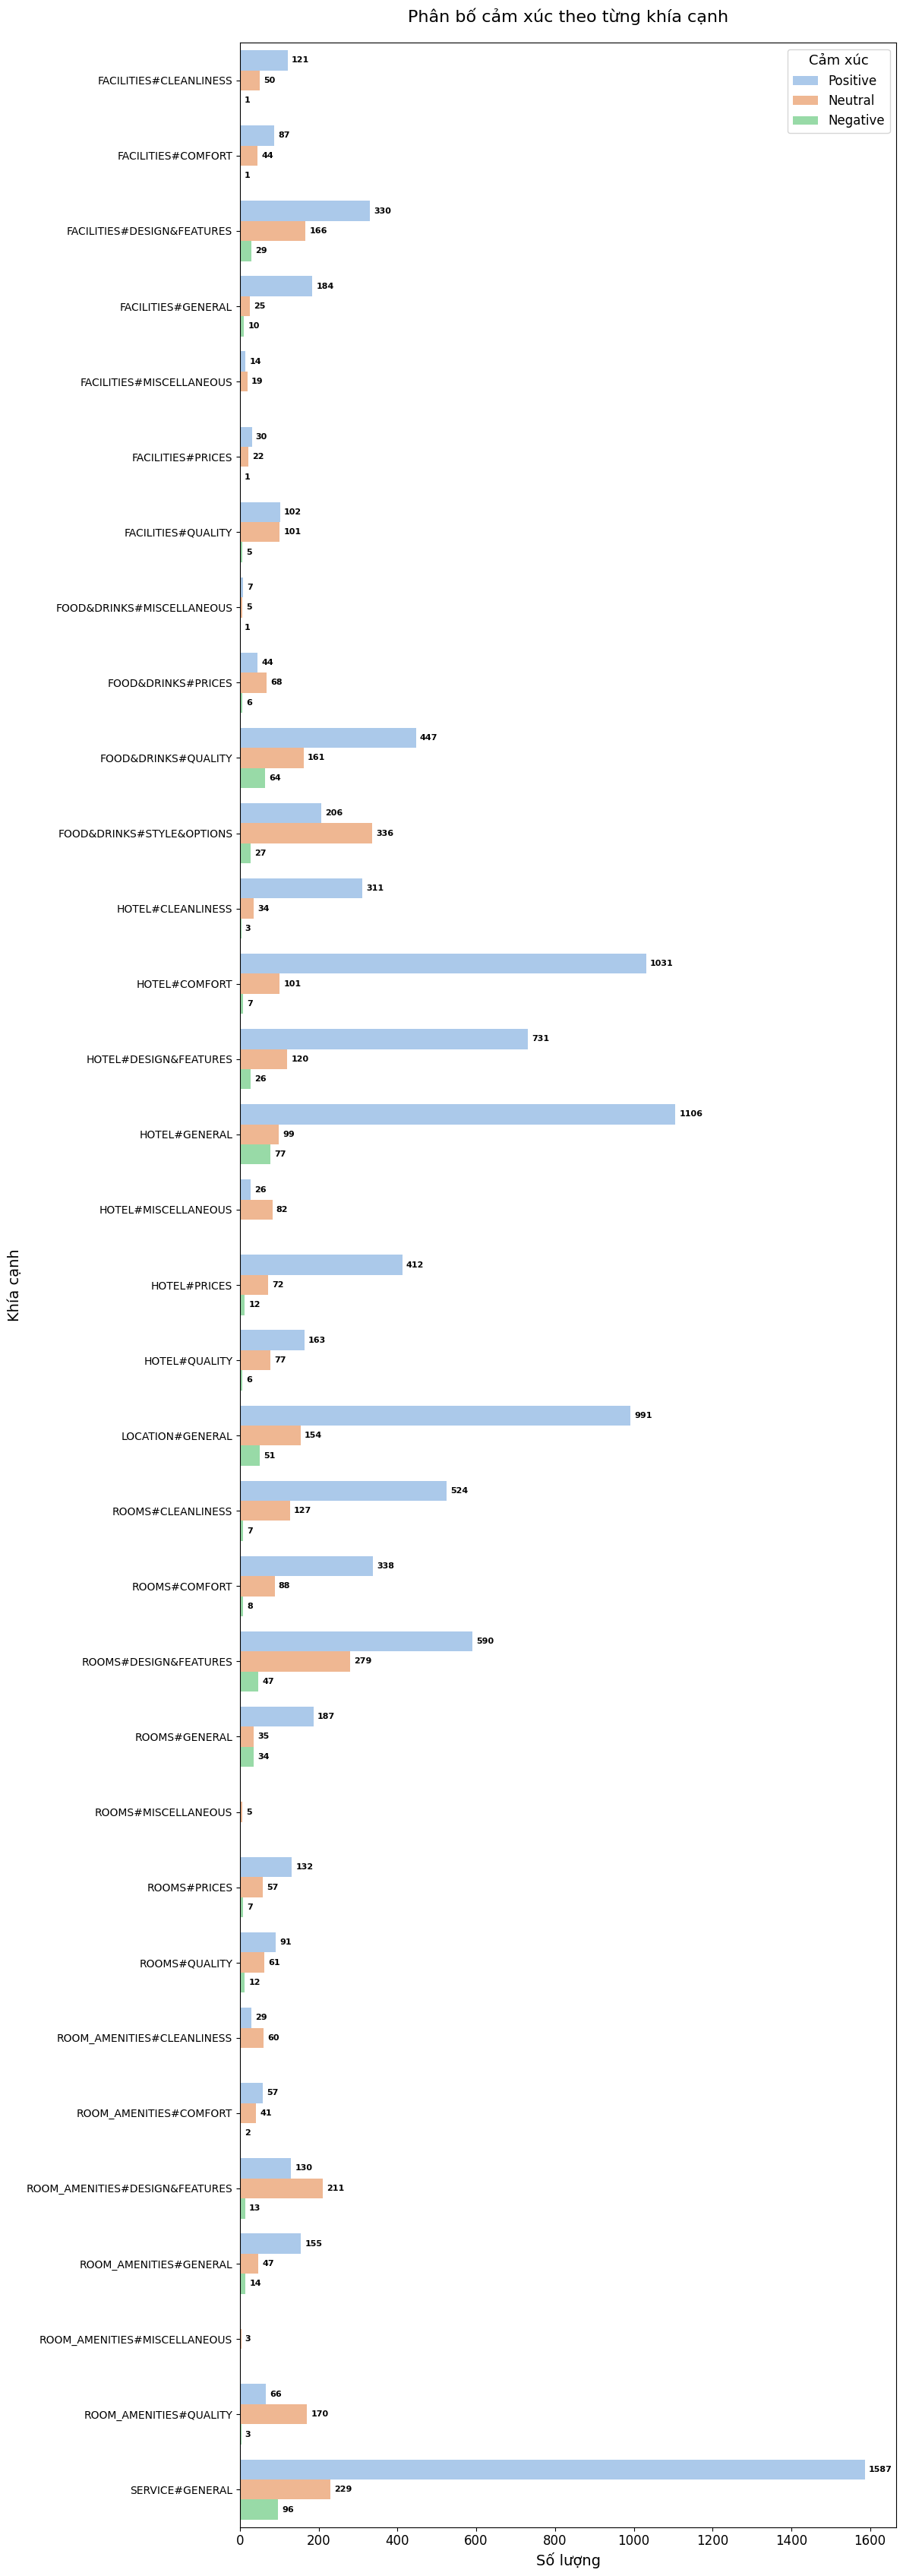

In [164]:
plt.figure(figsize=(12, 34))

# Dùng dodge=False nếu muốn cột các sentiment nằm đè lên nhau
# Nếu vẫn muốn tách nhóm theo sentiment: seaborn sẽ tự chia width, ta cần giảm số lượng nhóm và tăng figure height
bar_width = 0.7  # mặc định ~0.8, tăng lên cho dày
hotel_barplot = sns.barplot(
    y='aspect',
    x='count',
    hue='sentiment',
    data=hotel_sentiment_df,
    palette="pastel",
    dodge=True  # Giữ riêng các nhóm sentiment
)

# Truy cập từng cột để tăng độ rộng: seaborn không hỗ trợ trực tiếp nên nếu cần tùy chỉnh cực sâu thì phải vẽ thủ công bằng matplotlib

plt.title("Phân bố cảm xúc theo từng khía cạnh", fontsize=16, pad=20)
plt.xlabel("Số lượng", fontsize=14)
plt.ylabel("Khía cạnh", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.legend(title='Cảm xúc', fontsize=12, title_fontsize=13)

# Thêm số lên các cột
for p in hotel_barplot.patches:
    width = p.get_width()
    if width <= 0:
        continue
    hotel_barplot.text(width + 10, p.get_y() + p.get_height() / 2., int(width), 
                       ha="left", va="center", fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


### Phân bố số lượng khía cạnh trong mỗi đánh giá Hotel

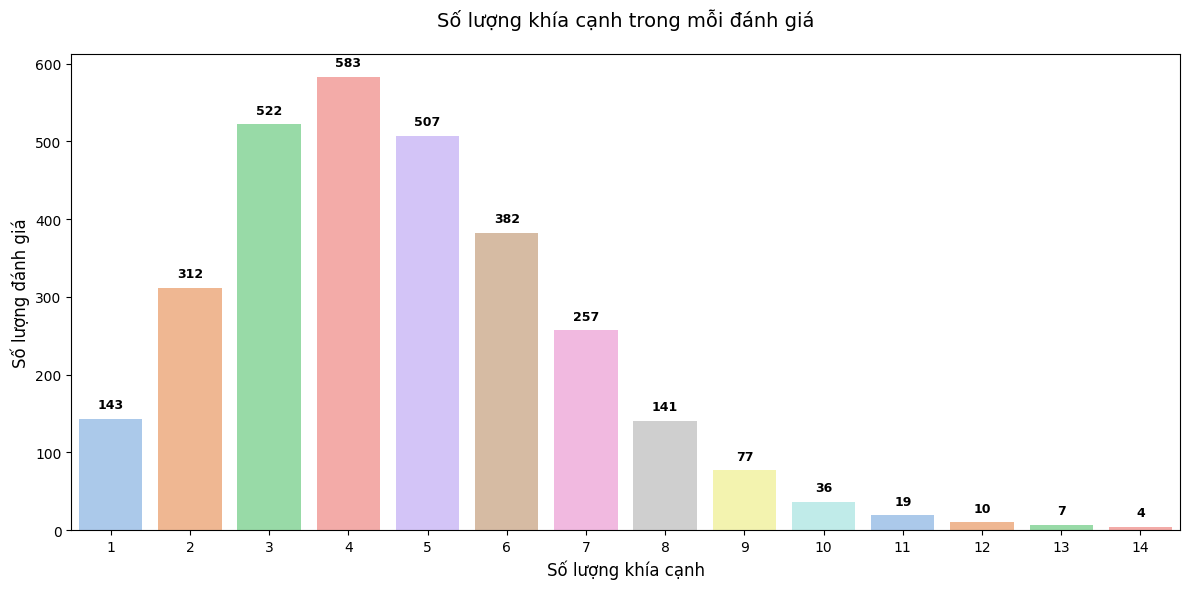

In [165]:
hotel_df['num_aspects'] = hotel_df[[a + '_exists' for a in hotel_aspects]].sum(axis=1)

plt.figure(figsize=(12, 6))
hotel_count_plot = sns.countplot(x='num_aspects', hue='num_aspects', data=hotel_df, palette="pastel", legend=False)
plt.title("Số lượng khía cạnh trong mỗi đánh giá", fontsize=14, pad=20)
plt.xlabel("Số lượng khía cạnh", fontsize=12)
plt.ylabel("Số lượng đánh giá", fontsize=12)

# Cải thiện hiển thị
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Thêm text số lượng trên đầu các cây cột
for p in hotel_count_plot.patches:
    height = p.get_height()
    if height <= 0:
        continue
    hotel_count_plot.text(p.get_x() + p.get_width() / 2., height + 10, int(height), ha="center", va="bottom", fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [166]:
# Kiểm tra có đánh giá nào có 0 khía cạnh không trong Hotel
zero_aspects_hotel = hotel_df[hotel_df['num_aspects'] == 0]
print(f"Số lượng đánh giá Hotel có 0 khía cạnh: {len(zero_aspects_hotel)}")
print(f"Tổng số đánh giá Hotel: {len(hotel_df)}")

# Kiểm tra phân bố số khía cạnh Hotel
print(f"\nPhân bố số khía cạnh Hotel:")
print(hotel_df['num_aspects'].value_counts().sort_index())

# So sánh 3 bộ dữ liệu
print(f"\n=== SO SÁNH 3 BỘ DỮ LIỆU ===")
print(f"\nBeauty Products:")
print(f"- Tổng số đánh giá: {len(df):,}")
print(f"- Số khía cạnh: {len(aspects)} khía cạnh")
print(f"- Có {len(zero_aspects_bp)} đánh giá có 0 khía cạnh")
print(f"- Số khía cạnh tối thiểu: {df['num_aspects'].min()}")
print(f"- Số khía cạnh tối đa: {df['num_aspects'].max()}")
print(f"- Trung bình: {df['num_aspects'].mean():.2f} khía cạnh/đánh giá")

print(f"\nRestaurant:")
print(f"- Tổng số đánh giá: {len(restaurant_df):,}")
print(f"- Số khía cạnh: {len(restaurant_aspects)} khía cạnh")
print(f"- Có 0 đánh giá có 0 khía cạnh")
print(f"- Số khía cạnh tối thiểu: {restaurant_df['num_aspects'].min()}")
print(f"- Số khía cạnh tối đa: {restaurant_df['num_aspects'].max()}")
print(f"- Trung bình: {restaurant_df['num_aspects'].mean():.2f} khía cạnh/đánh giá")

print(f"\nHotel:")
print(f"- Tổng số đánh giá: {len(hotel_df):,}")
print(f"- Số khía cạnh: {len(hotel_aspects)} khía cạnh")
print(f"- Có {len(zero_aspects_hotel)} đánh giá có 0 khía cạnh")
print(f"- Số khía cạnh tối thiểu: {hotel_df['num_aspects'].min()}")
print(f"- Số khía cạnh tối đa: {hotel_df['num_aspects'].max()}")
print(f"- Trung bình: {hotel_df['num_aspects'].mean():.2f} khía cạnh/đánh giá")

Số lượng đánh giá Hotel có 0 khía cạnh: 0
Tổng số đánh giá Hotel: 3000

Phân bố số khía cạnh Hotel:
num_aspects
1     143
2     312
3     522
4     583
5     507
6     382
7     257
8     141
9      77
10     36
11     19
12     10
13      7
14      4
Name: count, dtype: int64

=== SO SÁNH 3 BỘ DỮ LIỆU ===

Beauty Products:
- Tổng số đánh giá: 12,981
- Số khía cạnh: 8 khía cạnh
- Có 14 đánh giá có 0 khía cạnh
- Số khía cạnh tối thiểu: 0
- Số khía cạnh tối đa: 7
- Trung bình: 2.02 khía cạnh/đánh giá

Restaurant:
- Tổng số đánh giá: 2,961
- Số khía cạnh: 12 khía cạnh
- Có 0 đánh giá có 0 khía cạnh
- Số khía cạnh tối thiểu: 1
- Số khía cạnh tối đa: 10
- Trung bình: 3.14 khía cạnh/đánh giá

Hotel:
- Tổng số đánh giá: 3,000
- Số khía cạnh: 34 khía cạnh
- Có 0 đánh giá có 0 khía cạnh
- Số khía cạnh tối thiểu: 1
- Số khía cạnh tối đa: 14
- Trung bình: 4.65 khía cạnh/đánh giá


## 8. So sánh 3 bộ dữ liệu ViABSA

### Biểu đồ so sánh tổng quan

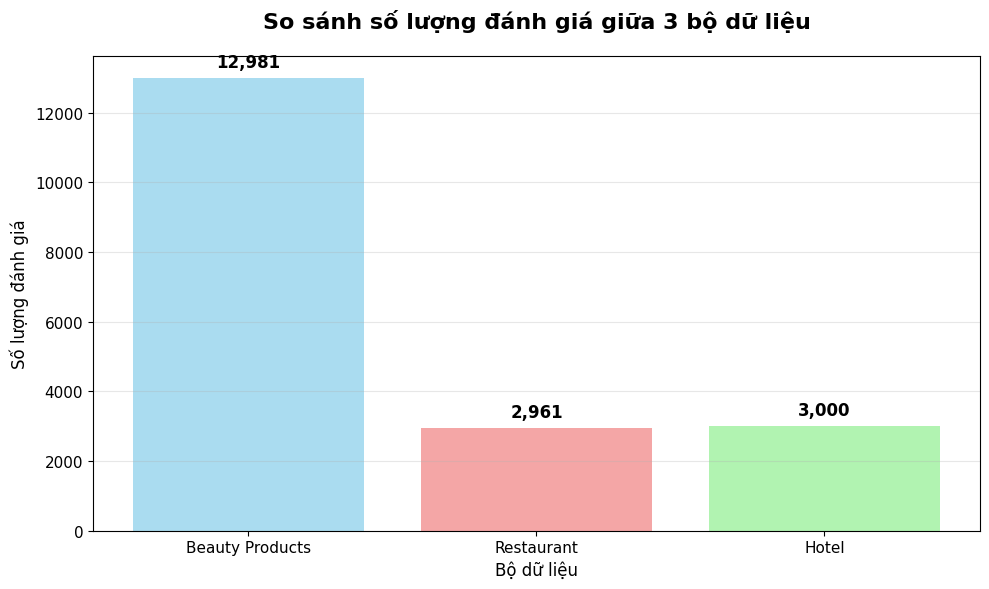

In [167]:
# Chuẩn bị dữ liệu so sánh
comparison_data = {
    'Dataset': ['Beauty Products', 'Restaurant', 'Hotel'],
    'Số đánh giá': [len(df), len(restaurant_df), len(hotel_df)],
    'Số khía cạnh': [len(aspects), len(restaurant_aspects), len(hotel_aspects)],
    'Trung bình khía cạnh/đánh giá': [df['num_aspects'].mean(), restaurant_df['num_aspects'].mean(), hotel_df['num_aspects'].mean()],
    'Số khía cạnh tối đa': [df['num_aspects'].max(), restaurant_df['num_aspects'].max(), hotel_df['num_aspects'].max()]
}

comparison_df = pd.DataFrame(comparison_data)

# 1. So sánh số lượng đánh giá
plt.figure(figsize=(10, 6))
bars1 = plt.bar(comparison_df['Dataset'], comparison_df['Số đánh giá'], 
                color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7)
plt.title('So sánh số lượng đánh giá giữa 3 bộ dữ liệu', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Số lượng đánh giá', fontsize=12)
plt.xlabel('Bộ dữ liệu', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Thêm text trên cột
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 200,
             f'{int(height):,}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

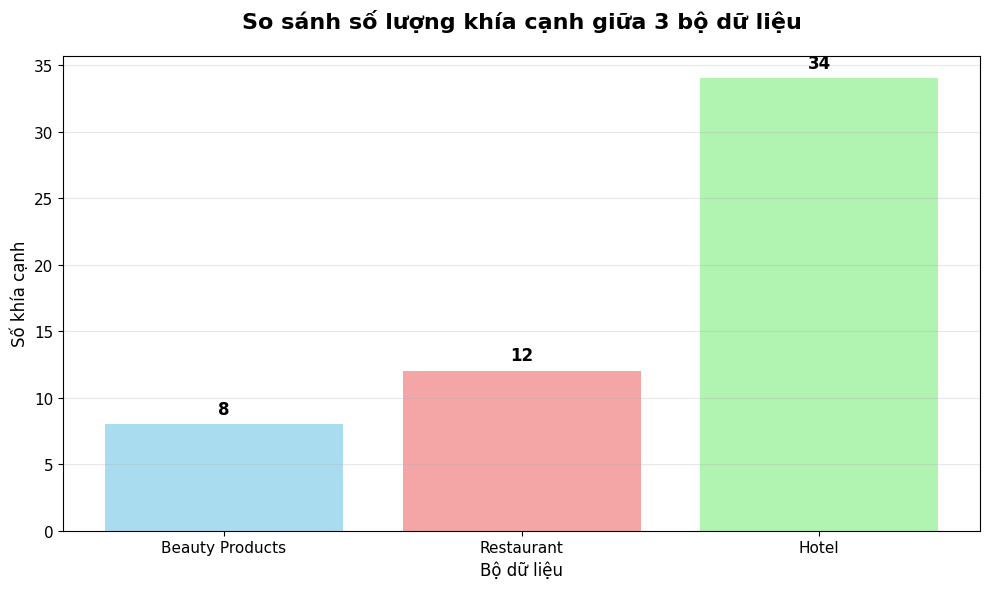

In [168]:
# 2. So sánh số lượng khía cạnh
plt.figure(figsize=(10, 6))
bars2 = plt.bar(comparison_df['Dataset'], comparison_df['Số khía cạnh'], 
                color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7)
plt.title('So sánh số lượng khía cạnh giữa 3 bộ dữ liệu', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Số khía cạnh', fontsize=12)
plt.xlabel('Bộ dữ liệu', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Thêm text trên cột
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

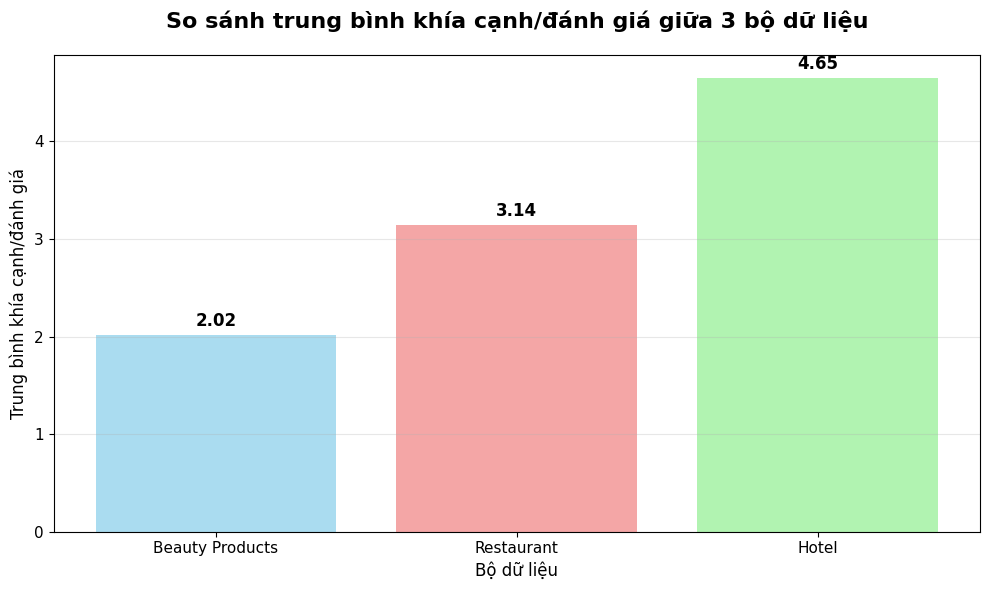

In [169]:
# 3. So sánh trung bình khía cạnh/đánh giá
plt.figure(figsize=(10, 6))
bars3 = plt.bar(comparison_df['Dataset'], comparison_df['Trung bình khía cạnh/đánh giá'], 
                color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7)
plt.title('So sánh trung bình khía cạnh/đánh giá giữa 3 bộ dữ liệu', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Trung bình khía cạnh/đánh giá', fontsize=12)
plt.xlabel('Bộ dữ liệu', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Thêm text trên cột
for bar in bars3:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

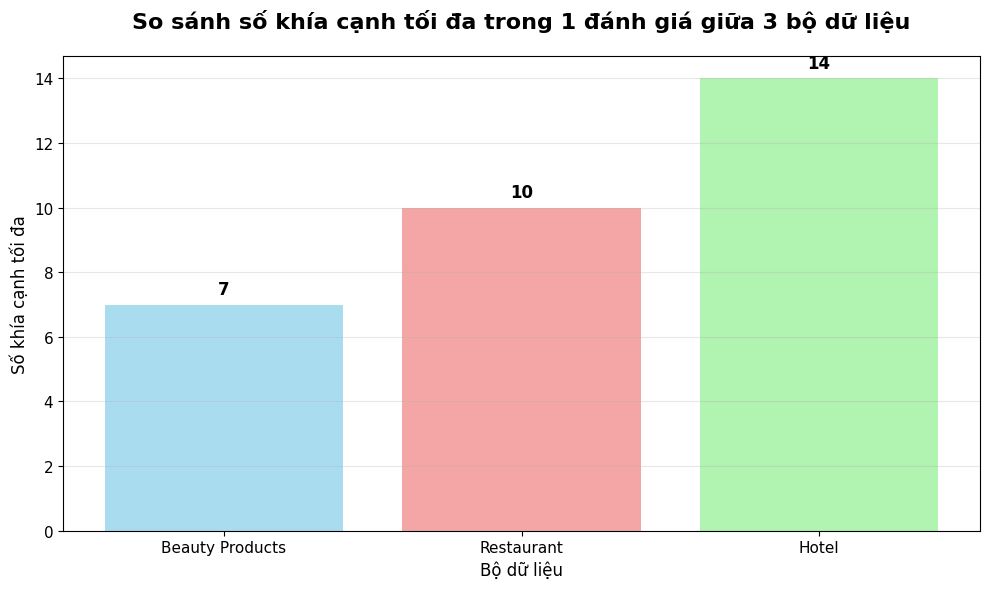

In [170]:
# 4. So sánh số khía cạnh tối đa trong 1 đánh giá
plt.figure(figsize=(10, 6))
bars4 = plt.bar(comparison_df['Dataset'], comparison_df['Số khía cạnh tối đa'], 
                color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7)
plt.title('So sánh số khía cạnh tối đa trong 1 đánh giá giữa 3 bộ dữ liệu', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Số khía cạnh tối đa', fontsize=12)
plt.xlabel('Bộ dữ liệu', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Thêm text trên cột
for bar in bars4:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### So sánh phân bố số lượng khía cạnh trong mỗi đánh giá

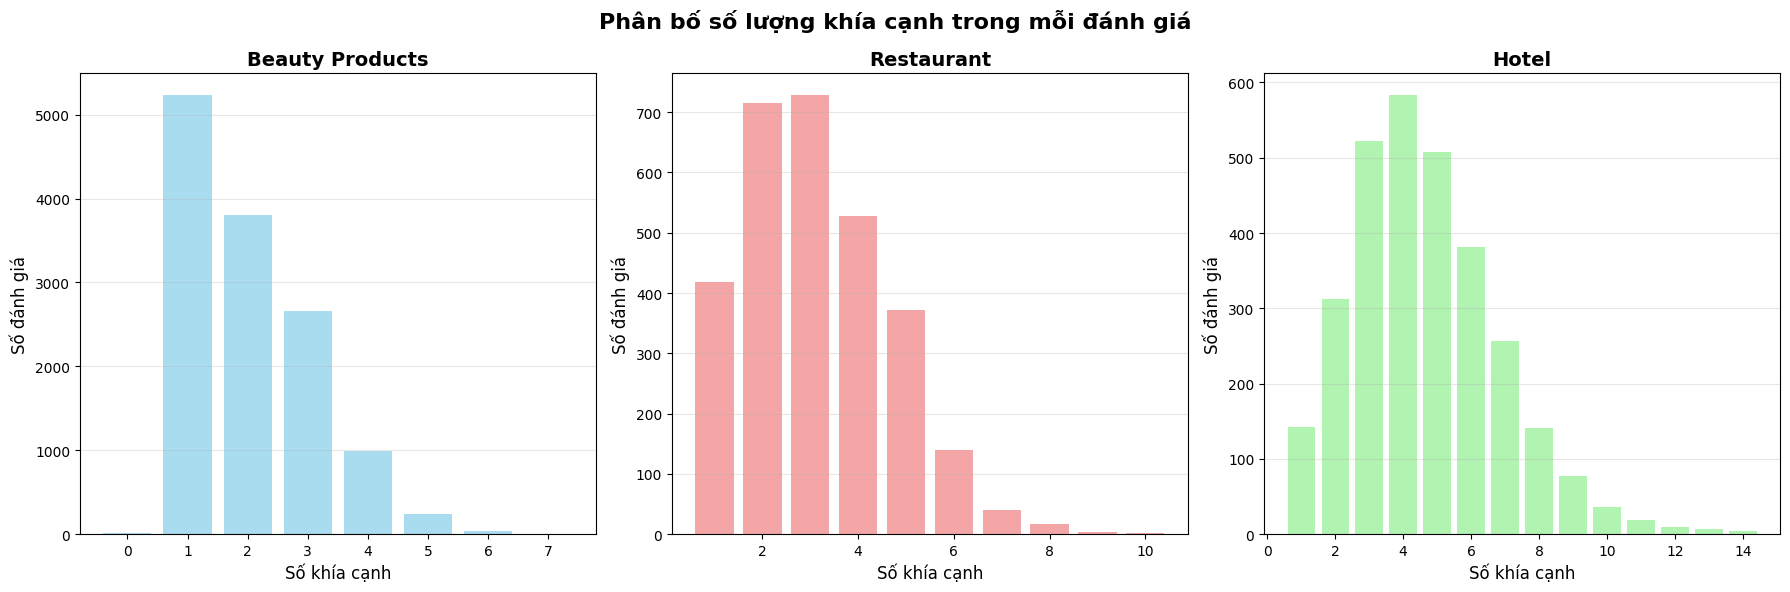

In [171]:
# 5. So sánh phân bố số lượng khía cạnh trong mỗi đánh giá
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Phân bố số lượng khía cạnh trong mỗi đánh giá', fontsize=16, fontweight='bold')

# Beauty Products
bp_counts = df['num_aspects'].value_counts().sort_index()
axes[0].bar(bp_counts.index, bp_counts.values, color='skyblue', alpha=0.7)
axes[0].set_title('Beauty Products', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Số khía cạnh', fontsize=12)
axes[0].set_ylabel('Số đánh giá', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Restaurant
restaurant_counts = restaurant_df['num_aspects'].value_counts().sort_index()
axes[1].bar(restaurant_counts.index, restaurant_counts.values, color='lightcoral', alpha=0.7)
axes[1].set_title('Restaurant', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Số khía cạnh', fontsize=12)
axes[1].set_ylabel('Số đánh giá', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# Hotel
hotel_counts = hotel_df['num_aspects'].value_counts().sort_index()
axes[2].bar(hotel_counts.index, hotel_counts.values, color='lightgreen', alpha=0.7)
axes[2].set_title('Hotel', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Số khía cạnh', fontsize=12)
axes[2].set_ylabel('Số đánh giá', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Bảng tóm tắt so sánh

In [172]:
# Tạo bảng tóm tắt so sánh đẹp
import pandas as pd

summary_data = {
    'Chỉ số': ['Tổng số đánh giá', 'Số khía cạnh', 'Trung bình khía cạnh/đánh giá', 
               'Số khía cạnh tối thiểu', 'Số khía cạnh tối đa', 'Đánh giá có 0 khía cạnh'],
    'Beauty Products': [f'{len(df):,}', len(aspects), f'{df["num_aspects"].mean():.2f}',
                       df['num_aspects'].min(), df['num_aspects'].max(), len(zero_aspects_bp)],
    'Restaurant': [f'{len(restaurant_df):,}', len(restaurant_aspects), f'{restaurant_df["num_aspects"].mean():.2f}',
                  restaurant_df['num_aspects'].min(), restaurant_df['num_aspects'].max(), 0],
    'Hotel': [f'{len(hotel_df):,}', len(hotel_aspects), f'{hotel_df["num_aspects"].mean():.2f}',
             hotel_df['num_aspects'].min(), hotel_df['num_aspects'].max(), len(zero_aspects_hotel)]
}

summary_df = pd.DataFrame(summary_data)
print("=" * 80)
print("BẢNG TÓM TẮT SO SÁNH 3 BỘ DỮ LIỆU ViABSA")
print("=" * 80)
print(summary_df.to_string(index=False))
print("=" * 80)

# Hiển thị bảng dưới dạng HTML để đẹp hơn
from IPython.display import HTML, display
styled_df = summary_df.style.set_table_attributes('style="border-collapse: collapse; margin: 25px 0; font-size: 0.9em; font-family: sans-serif; min-width: 400px; border-radius: 5px 5px 0 0; overflow: hidden; box-shadow: 0 0 20px rgba(0, 0, 0, 0.15);"')\
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#009879'), ('color', 'white'), ('font-weight', 'bold'), ('padding', '12px 15px'), ('text-align', 'left')]},
        {'selector': 'td', 'props': [('padding', '12px 15px'), ('border-bottom', '1px solid #dddddd')]},
        {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', '#f3f3f3')]},
        {'selector': 'tr:last-of-type', 'props': [('border-bottom', '2px solid #009879')]}
    ])

display(styled_df)

BẢNG TÓM TẮT SO SÁNH 3 BỘ DỮ LIỆU ViABSA
                       Chỉ số Beauty Products Restaurant Hotel
             Tổng số đánh giá          12,981      2,961 3,000
                 Số khía cạnh               8         12    34
Trung bình khía cạnh/đánh giá            2.02       3.14  4.65
       Số khía cạnh tối thiểu               0          1     1
          Số khía cạnh tối đa               7         10    14
      Đánh giá có 0 khía cạnh              14          0     0


,Chỉ số,Beauty Products,Restaurant,Hotel
0,Tổng số đánh giá,"12,981","2,961","3,000"
1,Số khía cạnh,8,12,34
2,Trung bình khía cạnh/đánh giá,2.02,3.14,4.65
3,Số khía cạnh tối thiểu,0,1,1
4,Số khía cạnh tối đa,7,10,14
5,Đánh giá có 0 khía cạnh,14,0,0
